# NYC Taxi Dataset COGS 109 Final

##### The cell below illustrates all of the libraries we plan on importing to use for our Final Project

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

## Cleaning Dataset 

##### Here is where we clean up our dataset. We plan on getting rid of variables that aren't needed and one-hot encode the variables that contain a string for their values. Also, for the sake of runtime, we will only be using 50000 data points.

In [4]:
dataset = pd.read_csv('nycTaxiDataset.csv')

dataset['Jan'] = np.where(dataset['pickup_date'] == 1, 1, 0)
dataset['Feb'] = np.where(dataset['pickup_date'] == 2, 1, 0)
dataset['Mar'] = np.where(dataset['pickup_date'] == 3, 1, 0)
dataset['Apr'] = np.where(dataset['pickup_date'] == 4, 1, 0)
dataset['May'] = np.where(dataset['pickup_date'] == 5, 1, 0)
dataset['Jun'] = np.where(dataset['pickup_date'] == 6, 1, 0)
dataset = dataset.drop(columns=['pickup_date'])

# Format purposes, target at the end
dataset['tripDuration'] = dataset['trip_duration']
dataset = dataset.drop(columns=['trip_duration'])
dataset.head()

,pickup_time,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Jan,Feb,Mar,Apr,May,Jun,tripDuration
0,17,1,-73.982155,40.767937,-73.964630,40.765602,0,0,1,0,0,0,455
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,0,0,0,0,1,663
2,11,1,-73.979027,40.763939,-74.005333,40.710087,1,0,0,0,0,0,2124
3,19,1,-74.010040,40.719971,-74.012268,40.706718,0,0,0,1,0,0,429
4,13,1,-73.973053,40.793209,-73.972923,40.782520,0,0,1,0,0,0,435


In [5]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X.shape)
print(y.shape)

(50000, 12)
(50000,)


## Initial Visualization

##### Below are some initial visualizations we illustrate to the user to show the relationship between one, two, or three variables. 

##### We want to see if we can distinguish a pattern right off the bat. Notice that for the duration portions of the graphs, we can see a pattern that some points lie very high in the duration column. We notice that there lies a cluster of points under 20,000 seconds and another around 80,000 seconds. 80,000 seconds translates to about 22 hours which seems very odd.

##### Our assumption is that this Kaggle dataset didn't correctly take into account travel times which started before midnight (PM) and ended after midnight (AM). It seems that they might have added an extrenous number to the actual travel time due to it being from one day to another. We will omit this later on in the project.

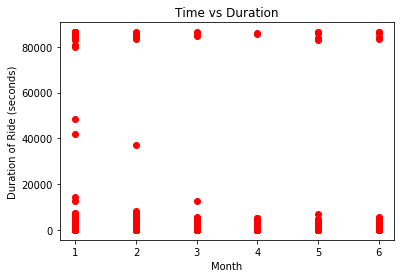

In [19]:
# Time vs Duration
timeAxis = dataset.iloc[:, 1].values
plt.title('Time vs Duration')
plt.xlabel('Month')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(timeAxis, y, color='red')
plt.show()

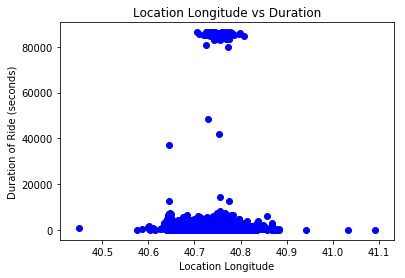

In [20]:
# Time vs Longitude
locationLongAxis = dataset.iloc[:, 3].values
plt.title('Location Longitude vs Duration')
plt.xlabel('Location Longitude')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(locationLongAxis, y, color='blue')
plt.show()

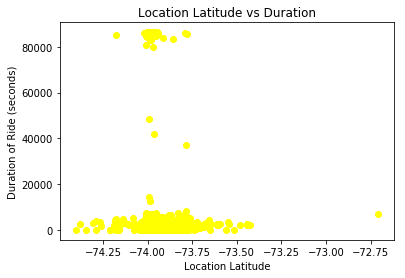

In [21]:
# Time vs Latitude
locationLatAxis = dataset.iloc[:, 4].values
plt.title('Location Latitude vs Duration')
plt.xlabel('Location Latitude')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(locationLatAxis, y, color='yellow')
plt.show()

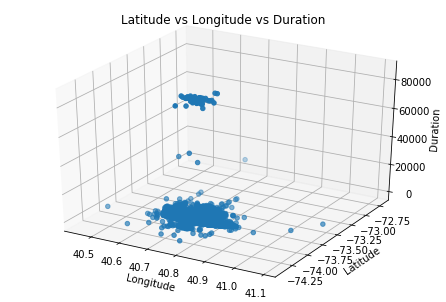

In [22]:
# Latitude vs Longitude vs Duration
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(locationLongAxis, locationLatAxis, y)
ax.set_title('Latitude vs Longitude vs Duration')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Duration')
plt.show()

# Linear Regression/Multi-Linear Regression

## OLS Original Dataset

##### First, I want to test how the raw dataset with the included outliers (80,000 seconds portion) will be as a linear model. This will give us a baseline and be our comparision to our cleaned up dataset which we will implement later. 

##### We implement a backward elimination technique to see which predictors we can omit. We come out with a R-squared value of 0.009 which is considered a very bad model for our dataset. Remember, the R-squared value tells us how much the variation in our target variable is explained by the predictor variables. This means that only 0.9% of the variation of our target variables can be explained by the predictors, hence, a bad model to predict the duartion of our trip. 

##### Since our dataset has some false outlier data, we expected our R-Squared value to be low. After running our backwards elimination and OLS summary, we are able to omit pickup time. Intuitively, we can see that this may not be the best idea because pickup time clearly affects the duration of a trip (traffic hour vs non-traffic hour) and we are able to conclude that this dataset is not optimal.

In [6]:
# Building the optimal model using Backwards Elimination
import statsmodels.formula.api as sm

# We have to add a column of 1s because statsmodels.formula.api doesn't account for b0
# To include b0 we can just have x0 = 1, which will tell statsmodel.formula.api to account for b0
# Adding X to an array full of 1s
X_opt = np.append(arr = np.ones((50000, 1)).astype(int), values = X, axis = 1)


# Fit the full model with all possible predictors
# regressor ordinary least squares
regressor_OLS =  sm.OLS(endog = y, exog = X_opt).fit()

regressor_OLS.summary()

# Omitting based on 0.5 threshold

# Omit 1st column (pickup time)
X_opt = np.delete(X_opt, 1, axis=1)
regressor_OLS =  sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

# Take column of 1s out from optimal model
X_opt = X_opt[:, 1:]
print(X_opt.shape)

(50000, 11)


## Custom RMSE Function

In [7]:
def custom_validation(random, model, X, y, folds, omit):
    x_error = []
    x_opt_error = []
    
    for i in range(folds):
        # randomize
        random = random.sample(frac=1)
        X = random.iloc[:, :-1].values
        y = random.iloc[:, -1].values
        
        # Size of test
        xRows, xCol = X.shape
        
        # Splitting the dataset into the Training set and Test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/folds, random_state = 0)
    
        # Size of test
        rows, col = X_test.shape
        
        if(model == 'linreg'):
            # Fitting Linear Regression to the Training set
            regressor = LinearRegression()
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        elif(model == 'polyReg') :
            poly = PolynomialFeatures(degree = 3)
            X_poly = poly.fit_transform(X_train)
            poly.fit(X_poly, y_train)
            regressor = LinearRegression()
            regressor.fit(X_poly, y_train)
            y_pred = regressor.predict(poly.fit_transform(X_test))
        elif (model == 'randomForest'):
            # Fitting Random Forest to the Training set
            regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        else:
            print('not linear regression')
        
        x_error.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
        ## Repeating for the most optimal predictors
        
        # Optimal X
        X_opt = np.delete(X, omit, axis=1)
        
        X_opt_train, X_opt_test, y_opt_train, y_opt_test = train_test_split(X_opt, y, test_size = 1/folds, random_state = 0)

        opt_rows, opt_cols = X_opt_test.shape

        if(model == 'linreg'):
            opt_regressor = LinearRegression()
            opt_regressor.fit(X_opt_train, y_opt_train)
            y_pred_opt = opt_regressor.predict(X_opt_test)
        elif(model == 'polyReg') :
            poly_opt = PolynomialFeatures(degree = 3)
            X_poly_opt = poly_opt.fit_transform(X_opt_train)
            poly_opt.fit(X_poly_opt, y_opt_train)
            regressor = LinearRegression()
            regressor.fit(X_poly_opt, y_opt_train)
            y_pred_opt = regressor.predict(poly_opt.fit_transform(X_opt_test))
        elif (model == 'randomForest'):
            opt_regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
            opt_regressor.fit(X_opt_train, y_opt_train)
            y_pred_opt = opt_regressor.predict(X_opt_test)
        else:
            print('not linear regression')

        x_opt_error.append(np.sqrt(mean_squared_error(y_opt_test, y_pred_opt)))
    
    return np.mean(x_error), np.mean(x_opt_error)

## Linear Model (Original Dataset)

##### This makes a call to the custom_validation function which returns us our RMSE for our model selected, in this case, a Linear Regression model. Our results indicate that our train and test predictors for both categories are pretty bad, predicting about 50 minutes off the duration time. Imagine taking a taxi cab in NYC with an estimated time of 60 minutes when it was actually only 10. You would probably think that this would be a bad predictor and never decide to trust it again. 

##### Remember, we expect a terrible RMSE because this is using the original dataset (our range of values are listed below). Also, note that this is taking into consideration trip that were 1 second which is impossible and the driver must have accidentally started the fare and shut it off immediately.

In [8]:
rmse = custom_validation(dataset, 'linreg', X, y, 10, 0)
print('The Linear Regression RMSE of all predictors', rmse[0])
print('The Linear Regression RMSE of the optimal predictors', rmse[1])
print('Largest value in y:', np.max(y))
print('Smallest value in y:', np.min(y))

The Linear Regression RMSE of all predictors 2973.2479097589953
The Linear Regression RMSE of the optimal predictors 2973.411083909363
Largest value in y: 86357
Smallest value in y: 1


## More Optimal Dataset Excluding Outliers

##### So this is where we actually make our most optimal dataset. Our dataset will first narrow down the scope of the trip duration to be between 5 minutes to 5 hours. We chose 5 minutes to be our initial low threshold because we figured that would normally be the decision where someone would take a cab instead of walking the distance. And we chose 20000 seconds (5 hours) to be our initial high threshold because, recall from the graphs in the beginning, most of the points lied under that. Then, we found the mean for the trip duration in that scope and took the data between the mean and two standard deviations from it to be our dataset which, now, excluded outliers. 

##### On a side note, we were able to take out almost 10,000 datapoints which were negtively affecting our models!

In [9]:
optDataset = dataset.drop(dataset[dataset.tripDuration > 20000].index)
optDataset = optDataset.drop(optDataset[optDataset.tripDuration < 300].index)
print(optDataset.shape)

optimalX = optDataset.iloc[:, :-1].values
optimalY = optDataset.iloc[:, -1].values

# Lets try it without outliers using stdev/mean
mean = np.mean(optimalY)
std = np.std(optimalY)

# low threshold is at least five minutes
lowThresh = mean - (2*std)
highThresh = mean + (2*std)
print('Low threshold:', lowThresh)
print('High threshold:', highThresh)

# Indexes to delete
optDataset = optDataset[optDataset.tripDuration < highThresh]
optDataset = optDataset[optDataset.tripDuration > lowThresh]

print(optDataset.shape)

(42324, 13)
Low threshold: -371.9424867572852
High threshold: 2266.9388009052864
(40400, 13)


In [10]:
optimalX = optDataset.iloc[:, :-1].values
optimalY = optDataset.iloc[:, -1].values
print(optimalX.shape)
print(optimalY.shape)
optimalRows, optimalCols = optimalX.shape

(40400, 12)
(40400,)


## OLS Optimal Dataset

##### Now, we repeat the backwards elimination process, except now with the optimal dataset. Instantly, we can see our R-squared value jumped up by almost 9%! This means we have to be doing something right. However, this is still relatively low compared to what a good model would have. The reasoning we might have a lower R-squared value would be because maybe the dataset isn't linear and therefore, a linear model isn't the most optimal model. 

##### Moving back to the OLS summary, we notice we can omit predictor 2 which is our 'passenger_count' column. Using our intuition, this seems like a predictor that would be irrelevant to our dataset because taking a taxi cab from point A to point B wouldn't depend on others. We can think of this as that people don't pick thier destination based on how many people they're with. For example, if I am at the airport and want to take uber back home, it wouldn't matter if 2 other people came with me or if I was going alone, I will still be travelling to the same desination.

In [11]:
omitX_opt = np.append(arr = np.ones((optimalRows, 1)).astype(int), values = optimalX, axis = 1)

# Fit the full model with all possible predictors
# regressor ordinary least squares
regressor_out_OLS =  sm.OLS(endog = optimalY, exog = omitX_opt).fit()
regressor_out_OLS.summary()

# Omit 2nd column (passenger count)
omitX_opt = np.delete(omitX_opt , 2, axis=1)
regressor_out_OLS =  sm.OLS(endog = optimalY, exog = omitX_opt).fit()
regressor_out_OLS.summary()

# Take column of 1s out from optimal model
omitX_opt = omitX_opt[:, 1:]
print(omitX_opt.shape)

(40400, 11)


## Linear Model (Optimal Dataset)

##### As we did above, we fit a linear regression model except now with out optimal dataset. For a linear model, we were very pleased with our results, reducing our RMSE to around 7 minutes. We can also see that by omitting passenger_count, is didn't actually help our model become better.

##### Comparing thise to the model above, we can see the effect of how cleaning up a dataset will produce better results. We were able to reduce our error by more than 40 minutes!

In [12]:
optRMSE = custom_validation(optDataset, 'linreg', optimalX, optimalY, 10, 1)
print('The Linear Regression RMSE of all train predictors in the optimal set', optRMSE[0])
print('The Linear Regression RMSE of the optimal test predictors in the optimal set', optRMSE[1])
print('Largest value in y:', np.max(optimalY))
print('Smallest value in y:', np.min(optimalY))

The Linear Regression RMSE of all train predictors in the optimal set 419.990837052146
The Linear Regression RMSE of the optimal test predictors in the optimal set 420.0121697676691
Largest value in y: 2266
Smallest value in y: 300


## Polynomial Regression

##### Comparing Polynomial Regression (degree = 3) to Linear Regression, we can conclude that our Polynomial Regression is better by about a minute. We ran through various degrees (1, 2, 3) and found out that 3 would give us the most optimal results. Degrees higher than 3 resulted in a runtime that was too long. We attempted to decrease the dataset size in order to speed up the runtime with higher degrees, however, we noticed that if the dataset was too small that the model would have a higher (worse) RMSE. 
with the total number of observations. When we decreased the observations in an attempt to improve run times, we saw that the results were not satisfactory. We concluded that degree 3 is the most optimal so that is what we use in the function custom_validation. 

##### As we can see, this model produces even better results than the ones above even if it is a couple of seconds! 

In [14]:
optRMSE = custom_validation(optDataset, 'polyReg', optimalX, optimalY, 10, 1)
print('The Polynomial Regression RMSE of all train predictors in the optimal set', optRMSE[0])
print('The Polynomail Regression RMSE of the optimal test predictors in the optimal set', optRMSE[1])
print('Largest value in y:', np.max(optimalY))
print('Smallest value in y:', np.min(optimalY))

The Polynomial Regression RMSE of all train predictors in the optimal set 349.46830891326476
The Polynomail Regression RMSE of the optimal test predictors in the optimal set 349.24869547556057
Largest value in y: 2266
Smallest value in y: 300


## Random Forest

##### Comparing the Random Forest with the Linear Regression, we can see that Random Forest brings us closer to our actual trip duration. We were able to go from a 7 minute error to only 4 minutes, almost half!

##### If you look into the code in the custom_validation function for calling the Random Forest Regressor, I chose n_estimates to have a parameter value of 100. In a Random Forest Regression, there comes a point that where if we increase the number of decision trees, our value eventually will converge. After many attempts tuning the n_estimates parameter (brute force and GridSearchCV on a local device for quicker runtime) I found that 100 is a happy medium of getting a good result while not being too long of a runtime. Increasing this value more will lead to a significant increase in runtime while obtaining almost the same value.

In [222]:
rfRMSE = custom_validation(optDataset, 'randomForest', optimalX, optimalY, 10, 1)
print('The Random Forest RMSE of all train predictors in the optimal set', rfRMSE[0])
print('The Random Forest RMSE of the optimal test predictors in the optimal set', rfRMSE[1])

The Random Forest RMSE of all train predictors in the optimal set 265.9476625190518
The Random Forest RMSE of the optimal test predictors in the optimal set 265.7427583204395
